***

# Appendix A: Predicting Bitcoin Prices with LSTM
  
This notebook uses the Keras wrapper around TensorFlow to demonstrate how a Long-Short Term Memory neural network can be used to effectively predict cryptocurrency prices. Predictions are based on daily (close) historic Bitcoin prices; a positive/negative semantic score computed from tweets by cryptocurrency experts; daily historic Economic Policy Uncertainty Index data; and Bitcoin market data including daily volume, bid-ask spread, and total transactions and transactions per minute. We explored numerous references for coding Long-Short Term Memory networks. One of the most useful guides is Jason Brownlee's [*"Machine Learning Mastery"*](https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/) series, and we have adapted some of his code to produce our models.


***

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
import numpy
from numpy import concatenate
import seaborn as sns
import matplotlib.pyplot as plt

/Users/tjd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# plot size
plt.rcParams["figure.figsize"] = (15,10)

***

## Part 1: Data preparation
Bitcoin price, volume, total transactions, trades per minute, bidask, the Economic Policy Uncertainty Index, and  semantic (tweet) scores were collected separately (see other appendices) and are loaded from a csv file here. The data cover 1,826 days of trading from March 24, 2013, through March 24, 2018.

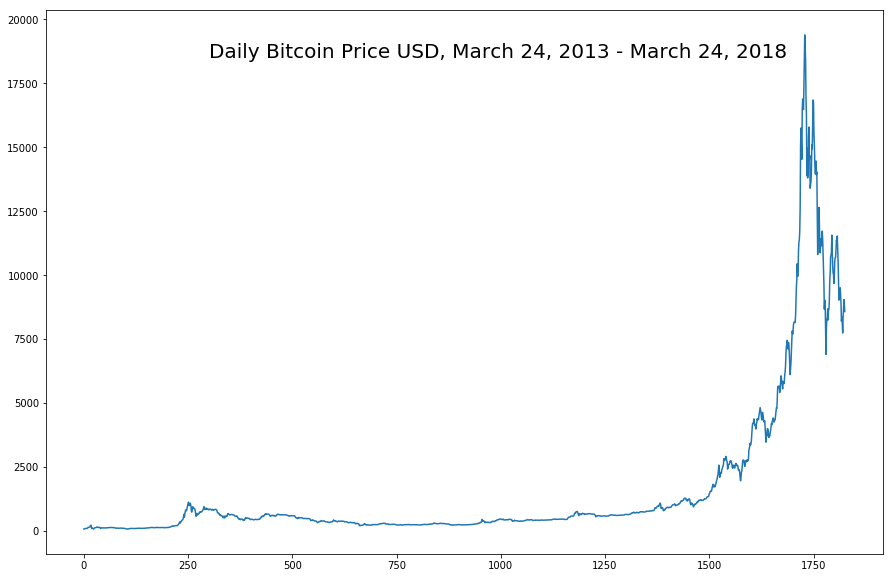

In [3]:
# get the data and view price timeline
fname='btc_new_3_24.csv'
df = pd.read_csv(fname)
df['price'].plot()
plt.text(300, 18500, "Daily Bitcoin Price USD, March 24, 2013 - March 24, 2018", fontsize=20) 
# plt.title("Daily Bitcoin Price USD, March 24, 2013 - March 24, 2018", fontsize=18)
plt.show()

### Function deck
These are some of the functions [Brownlee](https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/) devised to transform data and wrap around the LSTM modeling code. We are using adapted versions for our models. Similar functions are available in pandas and Keras. Note wrappers for 3 models.

In [4]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# frame a sequence as a supervised learning problem; NOT USED
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
# this base model uses hidden layers of 100, 20, 10 and 5 neurons
# the function can be easily modified to change layers 
# or use differently shaped input data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(10, return_sequences=True))
    model.add(LSTM(5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    return model

# model 2 uses fewer neurons in hidden layers
def fit2_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(LSTM(10, return_sequences=True))
    model.add(LSTM(5, return_sequences=True))
    model.add(LSTM(3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    return model

# model 3, takes 200 neurons and then 100
def fit3_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(LSTM(100))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    return model

# model 4, takes a single neuron over 500 epochs
# fit an LSTM network to training data
def fit4_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# model 5, deeper network, more epochs
def fit5_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(30, return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(10, return_sequences=True))
    model.add(LSTM(5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# this function runs the lstm model for the repeat experiment function below
# I've commented out the data prep part, since we've done that already
# run a repeated experiment
def experiment(n_repeats, batch_size=1, n_epochs=1, n_neurons=1):
	error_scores = list()
	for r in range(n_repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, batch_size, n_epochs, n_neurons)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-600:], predictions))
		print('')
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		print('')
		error_scores.append(rmse)
	return error_scores

# this function can be used to configure and run multiple trials of a model
# default is set to 2 repeats for a batch size of one with 10 epochs and 100 neurons
def run():
	n_repeats = 2
	batch_size = 1
	n_epochs = 10
	n_neurons = 100
	# run the experiment
	results = pd.DataFrame()
	results['results'] = experiment(n_repeats, batch_size, n_epochs, n_neurons)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment.csv', index=False)
    # save boxplot
	results.boxplot()
	plt.show()
 
# to run it
# run()


In [5]:
df.head()

,day,epu_idx,price,volume,bidask,tpm,trans,exp_sem
0,3/24/13,126.08,68.287939,3.361108e+06,0.761886,2.203646,51335,0.24065
1,3/25/13,178.57,73.648607,6.917269e+06,0.978241,2.824132,48993,0.20230
2,3/26/13,163.29,77.090928,5.322638e+06,0.931310,2.560417,49061,0.00000
3,3/27/13,177.06,85.256510,7.356470e+06,1.033937,3.198785,53207,0.21230
4,3/28/13,72.92,90.658741,1.477020e+07,1.555560,5.049826,60989,0.20240


### Difference the data
Several variables are not stationary (please refer to stationarity tests in Appendix C). For LSTM to work, they have to be differenced. We do that for transactions, bid-ask spread, volume and trades per minute. We also will difference price in a subsequent step.

In [6]:
# temporarily split off the variables to be differenced
df_temp = df[['trans', 'bidask', 'volume', 'tpm']].diff(1,0)

In [7]:
# concatenate the data, rename columns
new_df = pd.DataFrame(pd.concat([df_temp, df[['price','epu_idx', 'exp_sem']]], axis=1))

In [8]:
# note that differenced data is NaN in row 0, as it should be
new_df.head()

,trans,bidask,volume,tpm,price,epu_idx,exp_sem
0,NaN,NaN,NaN,NaN,68.287939,126.08,0.24065
1,-2342.0,0.216354,3556161.550,0.620486,73.648607,178.57,0.20230
2,68.0,-0.046930,-1594630.877,-0.263715,77.090928,163.29,0.00000
3,4146.0,0.102627,2033831.837,0.638368,85.256510,177.06,0.21230
4,7782.0,0.521623,7413732.351,1.851042,90.658741,72.92,0.20240


### Create the 1-day lagged price as target variable 'y'
We are trying to predict the next day's price based on the data we know today. The next series of steps adds our features together with y = t+1. So now we have the next day's true price (y) and today's knowledge (X) in each observation.

#### Step 1: Difference the price

In [9]:
# first we have to difference the price
# we're using Brownlee's function to do this so we can undifference it later
raw_values = new_df['price'].values
diff_values = difference(raw_values, 1)
diff_values.head()

0    5.360668
1    3.442321
2    8.165582
3    5.402231
4   -0.559414
dtype: float64

In [10]:
len(diff_values)

1825

In [11]:
# check it
new_df['price'].diff(1).head()

0         NaN
1    5.360668
2    3.442321
3    8.165582
4    5.402231
Name: price, dtype: float64

#### Step 2: Create our lagged ahead target price 'y'

In [12]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)

In [13]:
supervised[0:6]

,0,0
0,NaN,5.360668
1,5.360668,3.442321
2,3.442321,8.165582
3,8.165582,5.402231
4,5.402231,-0.559414
5,-0.559414,1.400072


#### Step 3: Combine with our other features

In [14]:
# note that data differenced data has NaN at row 0 as expected
new_df.head(5)

,trans,bidask,volume,tpm,price,epu_idx,exp_sem
0,NaN,NaN,NaN,NaN,68.287939,126.08,0.24065
1,-2342.0,0.216354,3556161.550,0.620486,73.648607,178.57,0.20230
2,68.0,-0.046930,-1594630.877,-0.263715,77.090928,163.29,0.00000
3,4146.0,0.102627,2033831.837,0.638368,85.256510,177.06,0.21230
4,7782.0,0.521623,7413732.351,1.851042,90.658741,72.92,0.20240


In [15]:
# concatenate the data, rename columns
df2 = pd.DataFrame(pd.concat([new_df, supervised], axis=1))

In [16]:
df2.columns.values[7] = "d-price"
df2.columns.values[8] = "y"

In [17]:
df2.head()

,trans,bidask,volume,tpm,price,epu_idx,exp_sem,d-price,y
0,NaN,NaN,NaN,NaN,68.287939,126.08,0.24065,NaN,5.360668
1,-2342.0,0.216354,3556161.550,0.620486,73.648607,178.57,0.20230,5.360668,3.442321
2,68.0,-0.046930,-1594630.877,-0.263715,77.090928,163.29,0.00000,3.442321,8.165582
3,4146.0,0.102627,2033831.837,0.638368,85.256510,177.06,0.21230,8.165582,5.402231
4,7782.0,0.521623,7413732.351,1.851042,90.658741,72.92,0.20240,5.402231,-0.559414


In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 9 columns):
trans      1825 non-null float64
bidask     1825 non-null float64
volume     1825 non-null float64
tpm        1825 non-null float64
price      1826 non-null float64
epu_idx    1826 non-null float64
exp_sem    1826 non-null float64
d-price    1824 non-null float64
y          1825 non-null float64
dtypes: float64(9)
memory usage: 128.5 KB


In [19]:
# delete old price column
df2.drop(['price'], axis=1, inplace=True)

#### Step 4: Inspect

In [20]:
# inspect; we should have seven features (X) and our target(y)
df2.head()

,trans,bidask,volume,tpm,epu_idx,exp_sem,d-price,y
0,NaN,NaN,NaN,NaN,126.08,0.24065,NaN,5.360668
1,-2342.0,0.216354,3556161.550,0.620486,178.57,0.20230,5.360668,3.442321
2,68.0,-0.046930,-1594630.877,-0.263715,163.29,0.00000,3.442321,8.165582
3,4146.0,0.102627,2033831.837,0.638368,177.06,0.21230,8.165582,5.402231
4,7782.0,0.521623,7413732.351,1.851042,72.92,0.20240,5.402231,-0.559414


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 8 columns):
trans      1825 non-null float64
bidask     1825 non-null float64
volume     1825 non-null float64
tpm        1825 non-null float64
epu_idx    1826 non-null float64
exp_sem    1826 non-null float64
d-price    1824 non-null float64
y          1825 non-null float64
dtypes: float64(8)
memory usage: 114.2 KB


In [22]:
# we must drop any NaN rows for LSTM to run
df2.dropna(inplace=True)

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1824 entries, 1 to 1824
Data columns (total 8 columns):
trans      1824 non-null float64
bidask     1824 non-null float64
volume     1824 non-null float64
tpm        1824 non-null float64
epu_idx    1824 non-null float64
exp_sem    1824 non-null float64
d-price    1824 non-null float64
y          1824 non-null float64
dtypes: float64(8)
memory usage: 128.2 KB


In [24]:
df2.head()

,trans,bidask,volume,tpm,epu_idx,exp_sem,d-price,y
1,-2342.0,0.216354,3556161.550,0.620486,178.57,0.202300,5.360668,3.442321
2,68.0,-0.046930,-1594630.877,-0.263715,163.29,0.000000,3.442321,8.165582
3,4146.0,0.102627,2033831.837,0.638368,177.06,0.212300,8.165582,5.402231
4,7782.0,0.521623,7413732.351,1.851042,72.92,0.202400,5.402231,-0.559414
5,1270.0,-0.430127,-5853453.366,-1.613368,90.71,0.240067,-0.559414,1.400072


In [25]:
len(df2)

1824

### Convert to an array
We now have a completed dataset with a lagged y to be predicted from other variables in each row. The next step is to convert the pandas dataframe to an array. This is required by LSTM.

In [26]:
supervised_values = df2.values
supervised_values[0:2]

array([[-2.34200000e+03,  2.16354374e-01,  3.55616155e+06,
         6.20486111e-01,  1.78570000e+02,  2.02300000e-01,
         5.36066752e+00,  3.44232118e+00],
       [ 6.80000000e+01, -4.69303670e-02, -1.59463088e+06,
        -2.63715277e-01,  1.63290000e+02,  0.00000000e+00,
         3.44232118e+00,  8.16558203e+00]])

In [27]:
len(supervised_values)

1824

### Make training, test sets; scale the data
We have 1,824 observations. We split the data into a training set of 1,224 rows and test set of 600 and scale each set between (-1,1) to improve model performance.

In [28]:
# split data into train and test-sets
train, test = supervised_values[0:-600, :], supervised_values[-600:, :]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [29]:
len(train), len(test)

(1224, 600)

***

## Part 2: Modeling
At this stage, we've attempted five LSTM models of different configurations. All reported similar results.  


### Model 1
This is a single-batch model run over 10 epochs with hidden layers of 100, 20, 10 and 5 hidden layers. Generally, deeper layers provide better results.

In [30]:
numpy.random.seed(1234)
lstm_model = fit_lstm(train_scaled, 1, 10, 100)

Epoch 1/1
 - 13s - loss: 0.0133
Epoch 1/1
 - 13s - loss: 0.0117
Epoch 1/1
 - 13s - loss: 0.0116
Epoch 1/1
 - 13s - loss: 0.0115
Epoch 1/1
 - 13s - loss: 0.0114
Epoch 1/1
 - 13s - loss: 0.0113
Epoch 1/1
 - 14s - loss: 0.0112
Epoch 1/1
 - 13s - loss: 0.0111
Epoch 1/1
 - 13s - loss: 0.0111
Epoch 1/1
 - 14s - loss: 0.0110


### Predictions on test data

In [31]:
predictions = list()
for i in range(len(test_scaled)):
	# predict
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
# report performance
rmse = sqrt(mean_squared_error(raw_values[-600:], predictions))
print('%d) Test RMSE: %.3f' % (1 ,rmse))

1) Test RMSE: 328.091


In [32]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1, 100)               43200     
_________________________________________________________________
lstm_2 (LSTM)                (1, 1, 20)                9680      
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 10)                1240      
_________________________________________________________________
lstm_4 (LSTM)                (1, 5)                    320       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    6         
Total params: 54,446
Trainable params: 54,446
Non-trainable params: 0
_________________________________________________________________


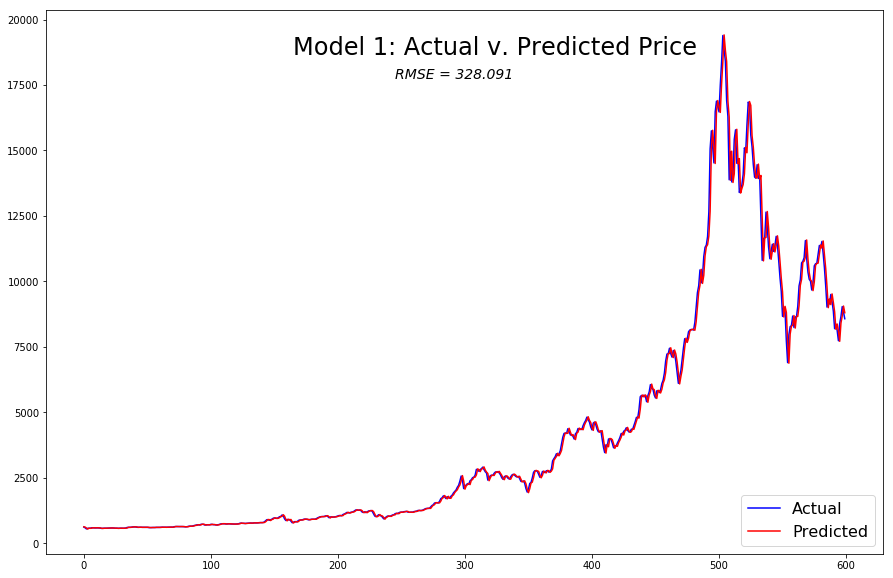

In [40]:
#Plot actual versus predicted:
orig = plt.plot(raw_values[-600:], color='blue',label='Actual')
pred = plt.plot(predictions, color='red', label='Predicted')
plt.legend(loc=4, fontsize=16)
plt.text(165, 18650, 'Model 1: Actual v. Predicted Price', fontsize=24)
plt.text(245, 17750, 'RMSE = 328.091', fontsize=14, style='italic' )
plt.show()

In [37]:
# save model
# serialize model to JSON
from keras.models import model_from_json
lstm_model_1 = lstm_model.to_json()
with open("lstm_model_1", "w") as json_file:
    json_file.write(lstm_model_1)
# serialize weights to HDF5
lstm_model.save_weights("model_1_weights.h5")
print("Saved model to disk")

Saved model to disk


### Model 2
This is a single-batch model run over 200 epochs with 50, 10, 5 and 3 hidden layers. This model takes appox. 40 minutes to complete.

In [38]:
numpy.random.seed(1234)
lstm_model = fit2_lstm(train_scaled, 1, 200, 50)

Epoch 1/1
 - 12s - loss: 0.0136
Epoch 1/1
 - 12s - loss: 0.0116
Epoch 1/1
 - 12s - loss: 0.0115
Epoch 1/1
 - 12s - loss: 0.0114
Epoch 1/1
 - 12s - loss: 0.0113
Epoch 1/1
 - 12s - loss: 0.0112
Epoch 1/1
 - 12s - loss: 0.0111
Epoch 1/1
 - 13s - loss: 0.0111
Epoch 1/1
 - 12s - loss: 0.0110
Epoch 1/1
 - 13s - loss: 0.0110
Epoch 1/1
 - 13s - loss: 0.0109
Epoch 1/1
 - 13s - loss: 0.0109
Epoch 1/1
 - 13s - loss: 0.0109
Epoch 1/1
 - 229s - loss: 0.0109
Epoch 1/1
 - 12s - loss: 0.0109
Epoch 1/1
 - 12s - loss: 0.0108
Epoch 1/1
 - 12s - loss: 0.0108
Epoch 1/1
 - 12s - loss: 0.0108
Epoch 1/1
 - 12s - loss: 0.0108
Epoch 1/1
 - 13s - loss: 0.0108
Epoch 1/1
 - 13s - loss: 0.0108
Epoch 1/1
 - 13s - loss: 0.0108
Epoch 1/1
 - 13s - loss: 0.0108
Epoch 1/1
 - 13s - loss: 0.0108
Epoch 1/1
 - 13s - loss: 0.0108
Epoch 1/1
 - 13s - loss: 0.0108
Epoch 1/1
 - 13s - loss: 0.0108
Epoch 1/1
 - 13s - loss: 0.0107
Epoch 1/1
 - 1055s - loss: 0.0107
Epoch 1/1
 - 12s - loss: 0.0107
Epoch 1/1
 - 12s - loss: 0.0107
Epoch

In [39]:
predictions_2 = list()
for i in range(len(test_scaled)):
	# predict
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions_2.append(yhat)
# report performance
rmse_2 = sqrt(mean_squared_error(raw_values[-600:], predictions_2))
print('%d) Test RMSE: %.3f' % (1 ,rmse_2))

1) Test RMSE: 326.061


In [41]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (1, 1, 50)                11600     
_________________________________________________________________
lstm_6 (LSTM)                (1, 1, 10)                2440      
_________________________________________________________________
lstm_7 (LSTM)                (1, 1, 5)                 320       
_________________________________________________________________
lstm_8 (LSTM)                (1, 3)                    108       
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    4         
Total params: 14,472
Trainable params: 14,472
Non-trainable params: 0
_________________________________________________________________


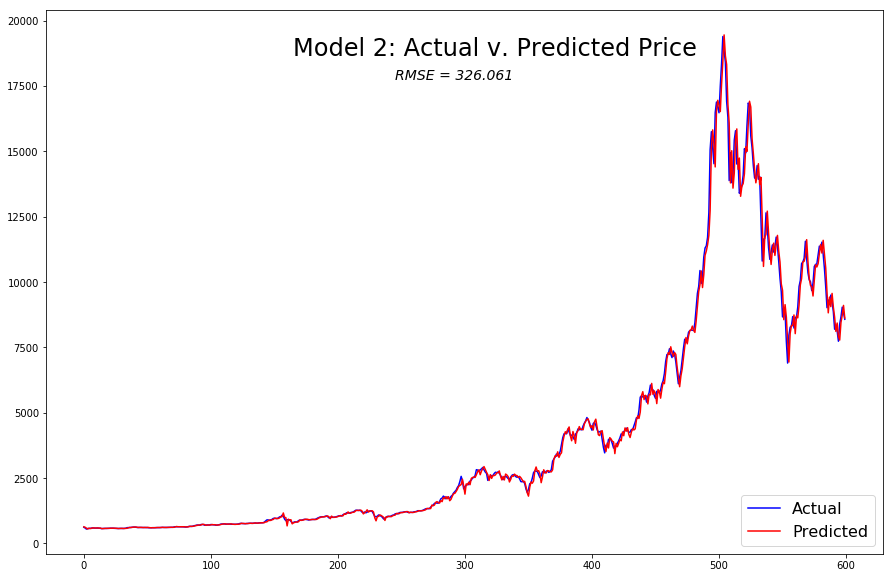

In [42]:
#Plot actual versus predicted:
orig = plt.plot(raw_values[-600:], color='blue',label='Actual')
pred = plt.plot(predictions_2, color='red', label='Predicted')
plt.legend(loc=4, fontsize=16)
plt.text(165, 18650, 'Model 2: Actual v. Predicted Price', fontsize=24)
plt.text(245, 17750, 'RMSE = 326.061', fontsize=14, style='italic' )
plt.show()

In [43]:
# save model
# serialize model to JSON
from keras.models import model_from_json
lstm_model_2 = lstm_model.to_json()
with open("lstm_model_2", "w") as json_file:
    json_file.write(lstm_model_2)
# serialize weights to HDF5
lstm_model.save_weights("model_2_weights.h5")
print("Saved model to disk")

Saved model to disk


### Model 3
Model with 100 epochs and five hidden layers of 200, 10, 5, 3, and 1 neurons. 

In [44]:
numpy.random.seed(1234)
lstm_model = fit3_lstm(train_scaled, 1, 100, 200)

Epoch 1/1
 - 9s - loss: 0.0125
Epoch 1/1
 - 8s - loss: 0.0119
Epoch 1/1
 - 8s - loss: 0.0117
Epoch 1/1
 - 9s - loss: 0.0117
Epoch 1/1
 - 8s - loss: 0.0116
Epoch 1/1
 - 8s - loss: 0.0116
Epoch 1/1
 - 9s - loss: 0.0115
Epoch 1/1
 - 9s - loss: 0.0114
Epoch 1/1
 - 9s - loss: 0.0114
Epoch 1/1
 - 9s - loss: 0.0113
Epoch 1/1
 - 9s - loss: 0.0113
Epoch 1/1
 - 9s - loss: 0.0113
Epoch 1/1
 - 9s - loss: 0.0112
Epoch 1/1
 - 9s - loss: 0.0112
Epoch 1/1
 - 9s - loss: 0.0112
Epoch 1/1
 - 9s - loss: 0.0111
Epoch 1/1
 - 9s - loss: 0.0111
Epoch 1/1
 - 9s - loss: 0.0111
Epoch 1/1
 - 9s - loss: 0.0111
Epoch 1/1
 - 9s - loss: 0.0110
Epoch 1/1
 - 8s - loss: 0.0110
Epoch 1/1
 - 8s - loss: 0.0110
Epoch 1/1
 - 9s - loss: 0.0110
Epoch 1/1
 - 9s - loss: 0.0110
Epoch 1/1
 - 9s - loss: 0.0110
Epoch 1/1
 - 9s - loss: 0.0109
Epoch 1/1
 - 9s - loss: 0.0109
Epoch 1/1
 - 9s - loss: 0.0109
Epoch 1/1
 - 9s - loss: 0.0109
Epoch 1/1
 - 9s - loss: 0.0109
Epoch 1/1
 - 9s - loss: 0.0109
Epoch 1/1
 - 9s - loss: 0.0108
Epoch 1/

In [45]:
predictions_3 = list()
for i in range(len(test_scaled)):
	# predict
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions_3.append(yhat)
# report performance
rmse_3 = sqrt(mean_squared_error(raw_values[-600:], predictions_3))
print('%d) Test RMSE: %.3f' % (1 , rmse_3))

1) Test RMSE: 334.549


In [87]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (1, 1, 200)               166400    
_________________________________________________________________
lstm_16 (LSTM)               (1, 100)                  120400    
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    101       
Total params: 286,901
Trainable params: 286,901
Non-trainable params: 0
_________________________________________________________________


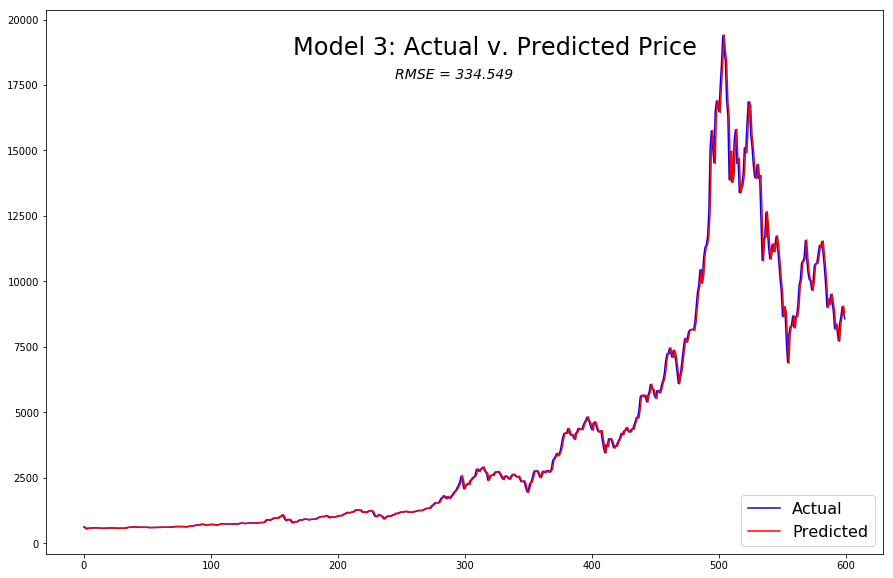

In [46]:
#Plot actual versus predicted:
orig = plt.plot(raw_values[-600:], color='blue',label='Actual')
pred = plt.plot(predictions, color='red', label='Predicted')
plt.legend(loc=4, fontsize=16)
plt.text(165, 18650, 'Model 3: Actual v. Predicted Price', fontsize=24)
plt.text(245, 17750, 'RMSE = 334.549', fontsize=14, style='italic')
plt.show()

In [47]:
# save model
# serialize model to JSON
from keras.models import model_from_json
lstm_model_3 = lstm_model.to_json()
with open("lstm_model_3", "w") as json_file:
    json_file.write(lstm_model_3)
# serialize weights to HDF5
lstm_model.save_weights("model_3_weights.h5")
print("Saved model to disk")

Saved model to disk


### Model 4
Model with 500 epochs and one layer of 10 neurons.

In [ ]:
numpy.random.seed(1234)
lstm_model = fit4_lstm(train_scaled, 1, 500, 100)

In [94]:
predictions_4 = list()
for i in range(len(test_scaled)):
	# predict
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions_4.append(yhat)
# report performance
rmse_4 = sqrt(mean_squared_error(raw_values[-600:], predictions_4))
print('%d) Test RMSE: %.3f' % (1 , rmse_4))

1) Test RMSE: 328.127


In [ ]:
lstm_model.summary()

In [ ]:
#Plot actual versus predicted:
orig = plt.plot(raw_values[-600:], color='blue',label='Actual')
pred = plt.plot(predictions, color='red', label='Predicted')
plt.legend(loc=4, fontsize=16)
plt.text(165, 18650, 'Model 4: Actual v. Predicted Price', fontsize=24)
plt.text(245, 17750, 'RMSE = 328.127', fontsize=14)
plt.show()

In [ ]:
# save model
# serialize model to JSON
from keras.models import model_from_json
lstm_model_4 = lstm_model.to_json()
with open("lstm_model_4", "w") as json_file:
    json_file.write(lstm_model_4)
# serialize weights to HDF5
lstm_model.save_weights("model_4_weights.h5")
print("Saved model to disk")

### Model 5
Model with 200 epochs and hidden layers of 100, 50, 30, 20, 10 and 5 neurons. 

In [100]:
numpy.random.seed(1234)
lstm_model = fit5_lstm(train_scaled, 1, 200, 100)

Epoch 1/1
 - 23s - loss: 0.0135
Epoch 1/1
 - 20s - loss: 0.0119
Epoch 1/1
 - 20s - loss: 0.0118
Epoch 1/1
 - 20s - loss: 0.0117
Epoch 1/1
 - 20s - loss: 0.0116
Epoch 1/1
 - 20s - loss: 0.0113
Epoch 1/1
 - 20s - loss: 0.0111
Epoch 1/1
 - 20s - loss: 0.0110
Epoch 1/1
 - 20s - loss: 0.0110
Epoch 1/1
 - 20s - loss: 0.0110
Epoch 1/1
 - 20s - loss: 0.0110
Epoch 1/1
 - 20s - loss: 0.0110
Epoch 1/1
 - 20s - loss: 0.0110
Epoch 1/1
 - 20s - loss: 0.0110
Epoch 1/1
 - 20s - loss: 0.0110
Epoch 1/1
 - 20s - loss: 0.0110
Epoch 1/1
 - 21s - loss: 0.0110
Epoch 1/1
 - 21s - loss: 0.0110
Epoch 1/1
 - 20s - loss: 0.0110
Epoch 1/1
 - 21s - loss: 0.0110
Epoch 1/1
 - 21s - loss: 0.0110
Epoch 1/1
 - 21s - loss: 0.0110
Epoch 1/1
 - 22s - loss: 0.0110
Epoch 1/1
 - 21s - loss: 0.0109
Epoch 1/1
 - 21s - loss: 0.0109
Epoch 1/1
 - 20s - loss: 0.0109
Epoch 1/1
 - 20s - loss: 0.0108
Epoch 1/1
 - 21s - loss: 0.0108
Epoch 1/1
 - 20s - loss: 0.0107
Epoch 1/1
 - 21s - loss: 0.0106
Epoch 1/1
 - 22s - loss: 0.0106
Epoch 1/

In [102]:
predictions_5 = list()
for i in range(len(test_scaled)):
	# predict
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions_5.append(yhat)
# report performance
rmse_5 = sqrt(mean_squared_error(raw_values[-600:], predictions_5))
print('%d) Test RMSE: %.3f' % (1 , rmse_5))

1) Test RMSE: 328.258


In [103]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (1, 1, 100)               43200     
_________________________________________________________________
lstm_20 (LSTM)               (1, 1, 50)                30200     
_________________________________________________________________
lstm_21 (LSTM)               (1, 1, 30)                9720      
_________________________________________________________________
lstm_22 (LSTM)               (1, 1, 20)                4080      
_________________________________________________________________
lstm_23 (LSTM)               (1, 1, 10)                1240      
_________________________________________________________________
lstm_24 (LSTM)               (1, 5)                    320       
_________________________________________________________________
dense_8 (Dense)              (1, 1)                    6         
Total para

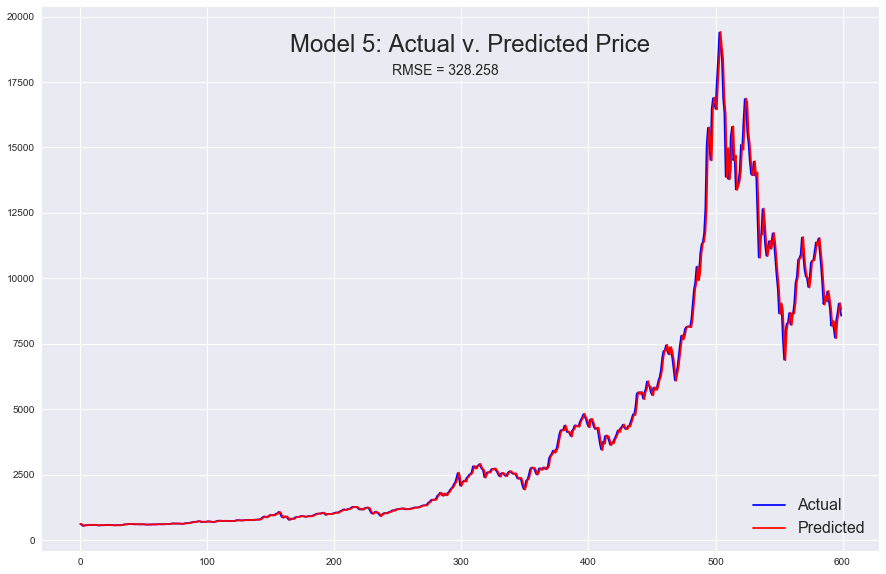

In [104]:
#Plot actual versus predicted:
orig = plt.plot(raw_values[-600:], color='blue',label='Actual')
pred = plt.plot(predictions, color='red', label='Predicted')
plt.legend(loc=4, fontsize=16)
plt.text(165, 18650, 'Model 5: Actual v. Predicted Price', fontsize=24)
plt.text(245, 17750, 'RMSE = 328.258', fontsize=14)
plt.show()

In [ ]:
# save model
# serialize model to JSON
from keras.models import model_from_json
lstm_model_5 = lstm_model.to_json()
with open("lstm_model_5", "w") as json_file:
    json_file.write(lstm_model_5)
# serialize weights to HDF5
lstm_model.save_weights("model_5_weights.h5")
print("Saved model to disk")

In [ ]:
# pd.DataFrame(predictions).to_csv('predict_3_24.csv'); new_df.to_csv('new_df_3_24.csv')

In [ ]:
# pd.DataFrame(raw_values[-600:]).to_csv('raw_values_3_24.csv')

***

## Part 3: Backtesting
We use results from our best-performing model to simulate gross profits/losses (i.e., excluding trading fees and taxes) from a $10,000 investment over the duration our five-year period. Long and long-short strategies show considerably larger gross profits than a buy-and-hold.

In [105]:
finaldf = pd.DataFrame()

In [106]:
finaldf['yhat'] = predictions_5
finaldf['actual'] = raw_values[-600:]

### Long only strategy

In [109]:
# Strategy is starting with $100,000. If we are predicting higher price tomorrow, we are going long.  
# If we are long and predicting lower, we are closing the position.

long = False
ballance = 1000000
position = 0
tbalance = 0

for i in range(1,len(finaldf)):
    if finaldf['yhat'][i] > finaldf['actual'][i-1] and not long:
        position = ballance/finaldf['actual'][i-1]
        ballance = ballance - finaldf['actual'][i-1]*position
        long = True
        print("Action: Buy", "\t" "price", finaldf['actual'][i-1], "\t" "Balance: ", ballance )
    if finaldf['yhat'][i] < finaldf['actual'][i-1] and long:
        ballance = ballance + position*finaldf['actual'][i-1]
        #tbalance = tbalance + (position*finaldf['actual'][i-1] -10000)
        position = 0
        long = False
        print("Action: sell","\t" "price", finaldf['actual'][i-1], "\t" "Balance: ", ballance)
    if i == len(finaldf) and long:
        ballance = ballance + position*finaldf['actual'][i]
        position = 0
        long = False
        print("Closed long")
    

#Final PNL
ballance     

Action: Buy 	price 550.2323023 	Balance:  0.0
Action: sell 	price 587.0532616 	Balance:  1066918.93432
Action: Buy 	price 593.4479862 	Balance:  0.0
Action: sell 	price 587.3153874 	Balance:  1055893.5607
Action: Buy 	price 587.2248494 	Balance:  0.0
Action: sell 	price 576.646713 	Balance:  1036872.93151
Action: Buy 	price 573.1198682 	Balance:  0.0
Action: sell 	price 579.3445188 	Balance:  1048134.40066
Action: Buy 	price 575.1770015 	Balance:  0.0
Action: sell 	price 574.2403722 	Balance:  1046427.59843
Action: Buy 	price 604.8187711 	Balance:  0.0
Action: sell 	price 612.2567719 	Balance:  1059296.46045
Action: Buy 	price 622.2924153 	Balance:  0.0
Action: sell 	price 622.9217192 	Balance:  1060367.6922
Action: Buy 	price 610.5118938 	Balance:  0.0
Action: sell 	price 612.321211 	Balance:  1063510.20511
Action: Buy 	price 614.0080525 	Balance:  0.0
Action: sell 	price 611.002838 	Balance:  1058304.9374
Action: Buy 	price 610.5484313 	Balance:  0.0
Action: sell 	price 610.1854495 	

19687869.869729411

### Long / Short  strategy

In [110]:
#Strategy is starting with $10,000. Long/short.
long = False
short = False
ballance = 1000000
longposition = 0
shortposition = 0

for i in range(1,len(finaldf)):
    if finaldf['yhat'][i] > finaldf['actual'][i-1] and not long and not short:
        longposition = ballance/finaldf['actual'][i-1]
        ballance = 0
        long = True
        print("Action: none, going long", "\t""price: ", finaldf['actual'][i-1], "\t""amount long: ", longposition, "\t""Ballance: ",ballance)
        
    if finaldf['yhat'][i] < finaldf['actual'][i-1] and not long and not short:
        shortposition = ballance/finaldf['actual'][i-1]
        ballance = ballance + finaldf['actual'][i-1]*(shortposition)
        short = True
        print("none, going short", "\t" "price: ", finaldf['actual'][i-1], "\t""amount short: ", shortposition, "\t""Ballance: ", ballance )
        
    if finaldf['yhat'][i] < finaldf['actual'][i-1] and long:
        ballance = ballance + longposition*finaldf['actual'][i-1] # sell
        longposition=0
        shortposition = ballance/finaldf['actual'][i-1] #short
        ballance = ballance + finaldf['actual'][i-1]*(ballance/finaldf['actual'][i-1])
        long = False
        short = True
        print("long, going short", "\t""price: ", finaldf['actual'][i-1], "\t""amount short: ", shortposition,"\t""Ballance: ", ballance)
        
    if finaldf['yhat'][i] > finaldf['actual'][i-1] and short:
        ballance = ballance - shortposition*finaldf['actual'][i-1] #cover
        shorptosition = 0
        short = False
        longposition = ballance/finaldf['actual'][i-1] # go long
        ballance = 0
        long = True
        print("short, going long", "\t""price: ", finaldf['actual'][i-1], "\t""amount long: ", longposition, "\t""Ballance: ",ballance)     
    
    if i == (len(finaldf)-1):
        if long:
            ballance = ballance + position*finaldf['actual'][i]
            position = 0
            long = False
            print("Closing long")
        if short:
            ballance = ballance - shortposition*finaldf['actual'][i]
            position = 0
            short = False
            print("Covered short")
        
        #print("Cashing out")
    

#Final PNL
ballance     

none, going short 	price:  620.2563179 	amount short:  1612.23670141 	Ballance:  2000000.0
short, going long 	price:  550.2323023 	amount long:  2022.59170041 	Ballance:  0
long, going short 	price:  587.0532616 	amount short:  2022.59170041 	Ballance:  2374738.10922
short, going long 	price:  593.4479862 	amount long:  1979.00265064 	Ballance:  0
long, going short 	price:  587.3153874 	amount short:  1979.00265064 	Ballance:  2324597.41686
short, going long 	price:  587.2248494 	amount long:  1979.6128937 	Ballance:  0
long, going short 	price:  576.646713 	amount short:  1979.6128937 	Ballance:  2283074.53632
short, going long 	price:  573.1198682 	amount long:  2003.97703749 	Ballance:  0
long, going short 	price:  579.3445188 	amount short:  2003.97703749 	Ballance:  2321986.22494
short, going long 	price:  575.1770015 	amount long:  2033.01717279 	Ballance:  0
long, going short 	price:  574.2403722 	amount short:  2033.01717279 	Ballance:  2334881.07598
short, going long 	price:  

long, going short 	price:  2324.181149 	amount short:  1063.17732475 	Ballance:  4942033.39244
short, going long 	price:  2495.685191 	amount long:  917.053759792 	Ballance:  0
long, going short 	price:  2764.690577 	amount short:  917.053759792 	Ballance:  5070739.7766
short, going long 	price:  2751.010088 	amount long:  926.174587032 	Ballance:  0
long, going short 	price:  2633.923639 	amount short:  926.174587032 	Ballance:  4878946.27725
short, going long 	price:  2583.746771 	amount long:  962.147570545 	Ballance:  0
long, going short 	price:  2724.361001 	amount short:  962.147570545 	Ballance:  5242474.6368
short, going long 	price:  2775.183747 	amount long:  926.907394723 	Ballance:  0
long, going short 	price:  2828.760316 	amount short:  926.907394723 	Ballance:  5243997.7096
short, going long 	price:  3147.13161 	amount long:  739.371096121 	Ballance:  0
long, going short 	price:  3354.059282 	amount short:  739.371096121 	Ballance:  4959788.97557
short, going long 	price

19465853.69784224

### Buy and Hold strategy

In [111]:
# Buying in with 10000 holding and selling at the end of test window.
(1000000/finaldf['actual'][0])*finaldf['actual'][599]

13823904.864089414